In [99]:
import utils
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np

data, _ = utils.load_data()


In [100]:
alerts = utils.extract_event(data, ['ACCIDENT']).drop("uuid", axis=1)

In [101]:
antof_grid = utils.grid(alerts, 10, 20)
antof_grid

(array([[-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 

In [102]:
alerts_grouped = alerts.copy()
alerts_grouped["group"] = alerts_grouped.to_crs(epsg=3857).geometry.apply(
    lambda x: utils.calc_quadrant(
        *utils.get_quadrant(
            *antof_grid,
            (
                x.x,
                x.y,
            ),
        ),
        antof_grid[0].shape[1] - 1,
    ),
)   

In [103]:
alerts_grouped["group"].value_counts()

group
132    103
159     41
141     37
48      37
149     28
      ... 
23       1
151      1
126      1
13       1
32       1
Name: count, Length: 92, dtype: int64

In [104]:
## Accidentes por grupo al día
grouped_day = (pd.DataFrame({"group": alerts_grouped.group.value_counts().keys(), "qty/day": alerts_grouped.group.value_counts().values / (alerts["inicio"].max() - alerts["inicio"].min()).days})).sort_values(ascending=False, by="qty/day")
grouped_day

,group,qty/day
0,132,1.839286
1,159,0.732143
2,141,0.660714
3,48,0.660714
4,149,0.500000
...,...,...
83,144,0.017857
86,57,0.017857
85,34,0.017857
84,85,0.017857


/var/folders/yx/rq7byh7s6351q7njcpzgf8_w0000gn/T/ipykernel_9481/587230641.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group_freq = float(grouped_day[grouped_day["group"] == quad]["qty/day"]) if quad in grouped_day["group"].values else 0


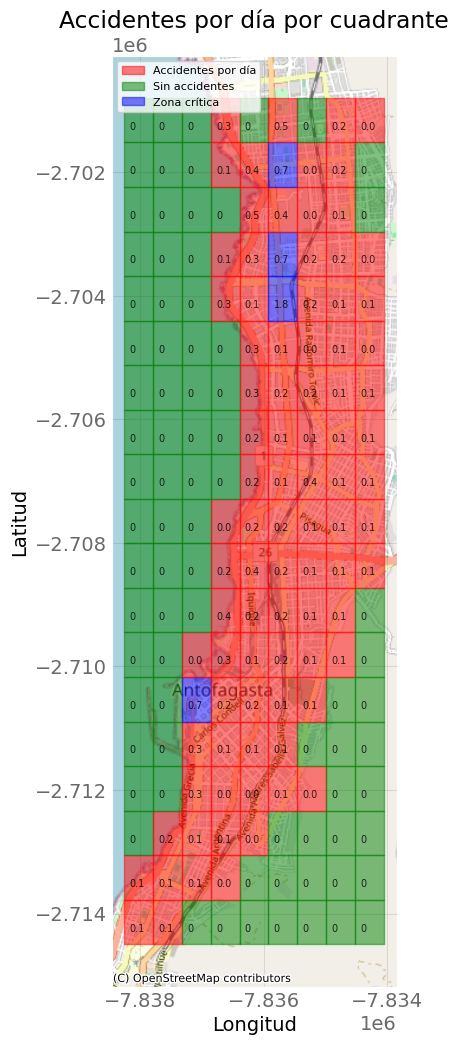

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        group_freq = np.float16(grouped_day[grouped_day["group"] == quad]["qty/day"])[0] if quad in grouped_day["group"].values else 0
        color = "r" if group_freq > 0 else "g"
        color = "b" if group_freq > 0.5 else color
        label = ""
        if group_freq == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True
        
        if group_freq > 0 and not labels[1] and label == "":
            label = "Accidentes por día"
            labels[1] = True

        if group_freq > 0.5 and not labels[2] and label == "":
            label = "Zona crítica"
            labels[2] = True

        ax.text(xp - 150, yp - 150, round(group_freq, 1), fontsize=7, alpha=0.8)
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(
    ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
)

plt.title("Accidentes por día por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.show()

/var/folders/yx/rq7byh7s6351q7njcpzgf8_w0000gn/T/ipykernel_9481/3927376811.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="upper left")


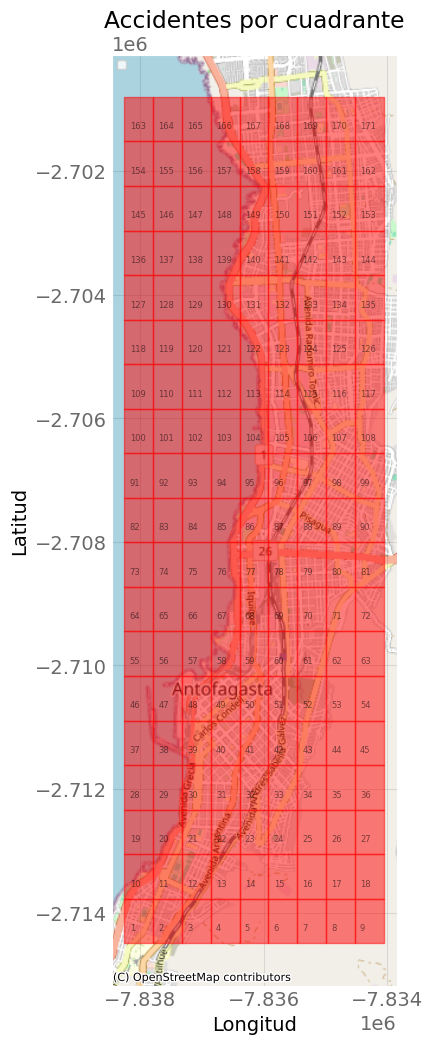

In [170]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (
                    alerts_grouped["group"].value_counts().max()
                    - alerts_grouped["group"].value_counts().min()
                )
            ) ,
            color="r"
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()

In [164]:
int(alerts_grouped.value_counts("group").reset_index()[alerts_grouped.value_counts("group").reset_index()["group"] == 132]["count"])

/var/folders/yx/rq7byh7s6351q7njcpzgf8_w0000gn/T/ipykernel_9481/3153385388.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(alerts_grouped.value_counts("group").reset_index()[alerts_grouped.value_counts("group").reset_index()["group"] == 132]["count"])


103

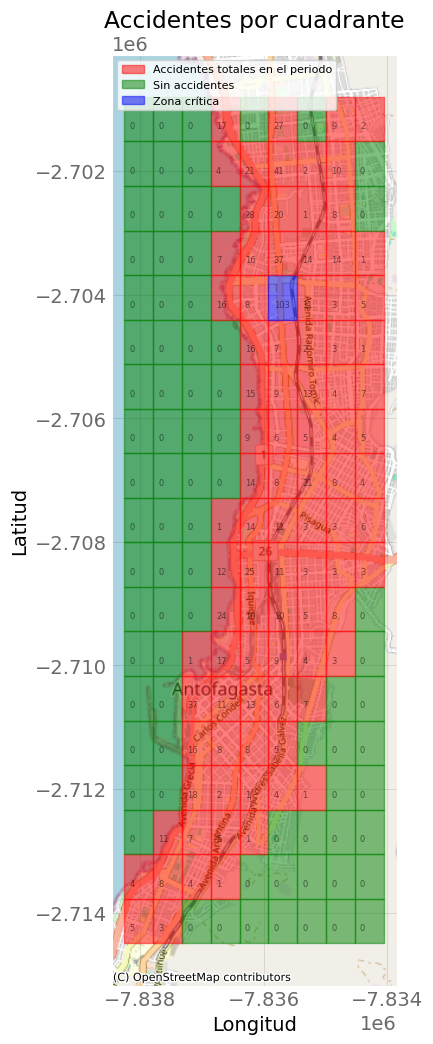

In [178]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)

        qty = (
            np.int16(
                alerts_grouped.value_counts("group").reset_index()[
                    alerts_grouped.value_counts("group").reset_index()["group"] == quad
                ]["count"]
            )[0]
            if quad
            in alerts_grouped.value_counts("group").reset_index()["group"].values
            else 0
        )

        color = "r" if qty > 0 else "g"
        color = "b" if qty > 60 else color
        label = ""
        if qty == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True
        
        if qty > 0 and not labels[1] and label == "":
            label = "Accidentes totales en el periodo"
            labels[1] = True

        if qty > 60 and not labels[2] and label == "":
            label = "Zona crítica"
            labels[2] = True

        ax.text(
            xp - 150,
            yp - 150,
            qty,
            fontsize=6,
            alpha=0.5,
        )
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(
    ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.show()


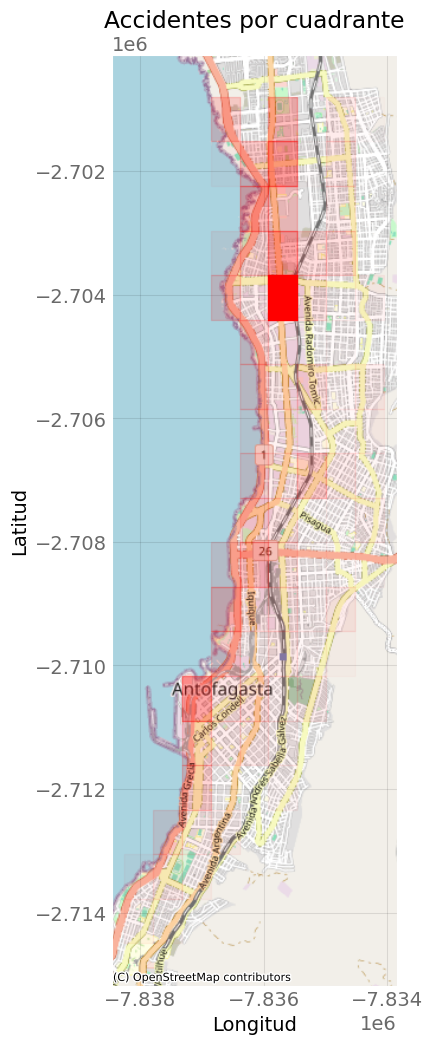

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        # ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (
                    alerts_grouped["group"].value_counts().max()
                    - alerts_grouped["group"].value_counts().min()
                )
            ) ,
            color="r"
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()

In [45]:
alerts_grouped

,street,inicio,fin,x,y,geometry,hour,minute,day,week_day,day_type,group
4,Irarrázaval,2024-08-23 11:12:19-04:00,2024-08-23 14:58:45-04:00,-70.385121,-23.603942,POINT (-7835235.829 -2705220.449),11,12,23,4,s,115
88,Díaz Gana,2024-08-23 14:34:02-04:00,2024-08-23 14:58:45-04:00,-70.403283,-23.665486,POINT (-7837257.614 -2712698.778),14,34,23,4,s,21
89,Av. Angamos,2024-08-23 14:33:40-04:00,2024-08-23 14:58:45-04:00,-70.403216,-23.665352,POINT (-7837250.155 -2712682.492),14,33,23,4,s,21
96,Av. Edmundo Pérez Zujovic,2024-08-23 14:43:35-04:00,2024-08-23 14:58:45-04:00,-70.396410,-23.628191,POINT (-7836492.515 -2708166.572),14,43,23,4,s,76
101,Av. Grecia,2024-08-23 15:29:55-04:00,2024-08-23 14:58:45-04:00,-70.402631,-23.654842,POINT (-7837185.033 -2711405.154),15,29,23,4,s,39
...,...,...,...,...,...,...,...,...,...,...,...,...
12549,Av. Pedro Aguirre Cerda,2024-10-18 13:10:02-03:00,2024-10-17 21:07:39-03:00,-70.389581,-23.597298,POINT (-7835732.314 -2704413.334),13,10,18,4,s,123
12552,Av. Pedro Aguirre Cerda,2024-10-18 13:09:38-03:00,2024-10-17 21:07:39-03:00,-70.389612,-23.596856,POINT (-7835735.765 -2704359.641),13,9,18,4,s,132
12556,Av. Pedro Aguirre Cerda,2024-10-18 13:09:00-03:00,2024-10-17 21:07:39-03:00,-70.389672,-23.595358,POINT (-7835742.444 -2704177.67),13,9,18,4,s,132
12558,Av. Pedro Aguirre Cerda,2024-10-18 13:07:54-03:00,2024-10-17 21:07:39-03:00,-70.389726,-23.593445,POINT (-7835748.455 -2703945.289),13,7,18,4,s,132


In [46]:
alerts_cleaned = alerts_grouped.drop(["street", "inicio", "fin", "x", "y", "geometry", "day"], axis=1)
results = utils.xgb_classifier(alerts_cleaned, "happen", ohe=False)

[0.85492228 0.78238342 0.8134715  0.83419689 0.72020725 0.80310881
 0.82291667 0.82291667 0.77604167 0.86458333]
0.8094748488773748


In [47]:
xgb = results["model"]

In [48]:
xgb.predict(results["X_test"])

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,

In [49]:
results["X_train"]

,hour,minute,week_day,day_type,group
840,5,50,2,1,21
1895,18,37,4,1,105
89,14,33,4,1,21
286,0,55,1,0,81
837,7,57,0,1,30
...,...,...,...,...,...
167,22,58,2,1,48
331,7,40,2,0,58
11357,1,0,0,1,158
496,12,42,3,0,98


In [50]:
day_type = 1
hour = 7
minute = 30
week_day = 3
group = 76

In [51]:
# Preparing a sample with the same structure as X_train_happen
obj = pd.DataFrame(columns=results["X_train"].columns)
obj.loc[0] = 0  # Initialize all values to 0

probs = []

# Set desired features
obj["day_type"] = day_type
obj["hour"] = hour
obj["minute"] = minute
obj["week_day"] = week_day
obj["group"] = group

prob_happen = xgb.predict_proba(obj)
prob_happen


array([[0.3829043, 0.6170957]], dtype=float32)

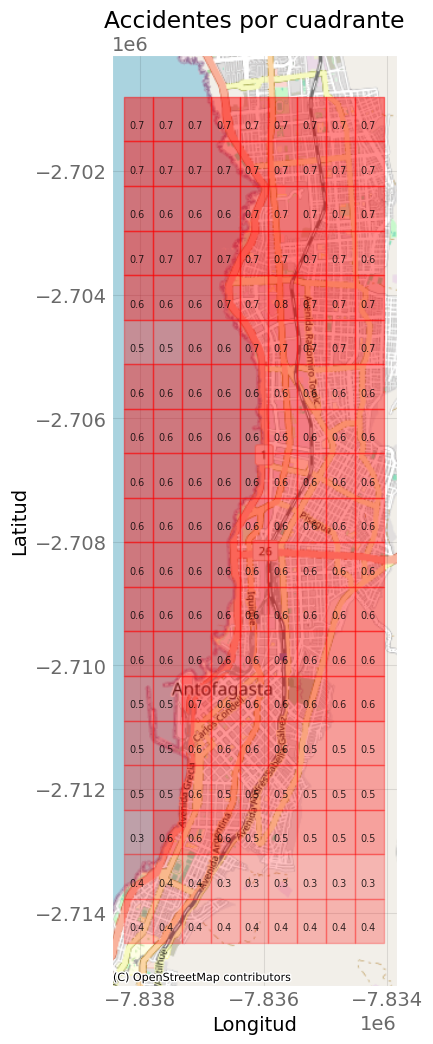

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        obj["group"] = quad
        pred = xgb.predict_proba(obj)[0][1]
        ax.text(xp - 150, yp - 150, round(pred, 1), fontsize=7, alpha=0.8)
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=pred*0.7,
            color="r",
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()
    